In [171]:
import pandas as pd
import scipy.stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [93]:
df = pd.read_csv("credit_card_default_analysis.csv")

In [94]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### 1. Размер кредитного лимита

In [172]:
X_lim0 = df[df['default'] == 0]['LIMIT_BAL'].values
X_lim1 = df[df['default'] == 1]['LIMIT_BAL'].values

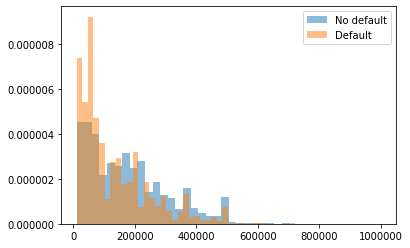

In [194]:
plt.hist(X_lim0, bins=40, alpha=0.5, label='No default', density=True)
plt.hist(X_lim1, bins=40, alpha=0.5, label='Default', density=True)
plt.legend(loc='upper right')
plt.show()

По графику не видно каких-то значимых различий в распределениях.

In [150]:
# доверительный интервал для разности медиан

# построим с помощью бутстрепа

def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries


lim0_median_scores = np.median(get_bootstrap_samples(X_lim0, 1000), axis = 1)
lim1_median_scores = np.median(get_bootstrap_samples(X_lim1, 1000), axis = 1)

In [104]:
delta_median_scores = lim0_median_scores - lim1_median_scores
print("Доверительный интервал с на уровне доверия 95%",  stat_intervals(delta_median_scores, 0.05))

Доверительный интервал с на уровне доверия 95% [60000. 70000.]


In [195]:
# проверим гипотезу о равенстве распределений против гипотезы об их различии на некоторый сдвиг
# с помощью критерия Манна-Уитни

scipy.stats.mannwhitneyu(X_lim0, X_lim1)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

Вывод: доверительный интервал для разности медиан не включает ноль, а достигаемый уровень значимости при проверке гипотезы на равенство распределений практически равен нулю.
Можно утверждать, что медианы кредитных лимитов отличанаются.

Левый конец построенного доверительного интервала довольно сильно удалён от нуля, откуда можно сделать вывод о том,
что различие практически значимо.

### 2. Пол

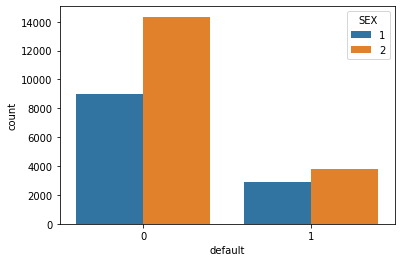

In [212]:
sns.countplot(df['default'], hue=df['SEX']);

Можно заключить из графика, что среди вернувших кредит женщин примерно в полтора раза больше, чем мужчин.
Однако, при этом женщин несколько больше и среди должников, так что по графику нельзя сделать однозначных выводов.

In [214]:
# построим нормальный доверительный интервал для разности долей
# и воспользуемся критерием Стьюдента для проверки гипотезы о их равенстве

def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [215]:
X_sex0 = df[df['default'] == 0]['SEX'].values - 1
X_sex1 = df[df['default'] == 1]['SEX'].values - 1

proportions_confint_diff_ind(X_sex0, X_sex1)

(0.03363493274962867, 0.060548077974896725)

In [108]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)
    
proportions_diff_z_test(proportions_diff_z_stat_ind(X_sex0, X_sex1))

4.472866521609831e-12

Полученный достигаемый уровень значимости позволяет отвергнуть гипотезу о равенстве долей против двусторонней асльтернативы на уровне значимости 0.05, а доверительный интервал для разности долей не содержит ноль, откуда также можно сделать вывод, что доли различаются.

### 3. Образование

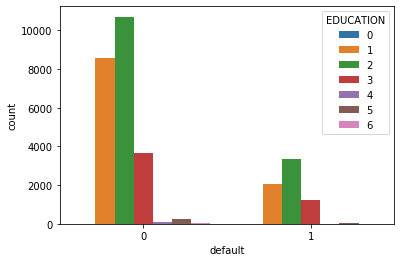

In [217]:
sns.countplot(df['default'], hue=df['EDUCATION']);

Виден большой дисбаланс между числами людей с разным образованием. Логично, что людям без хотя бы среднего образования кредиты не одобряют либо их просто очень мало, как и докторов.

Можно заметить больший разрыв между группами 1-2 и остальными группами.

In [241]:
# построим матрицу частот и проверим гипотезу о независимости переменных против гипотезы
# о том, что между ними есть взаимосвязь с помощью критерия хи-квадрат

confmat = pd.crosstab(df['default'], df['EDUCATION'])

In [238]:
# для начала проверим условия применимости
# выборка достаточно большая, так что остаётся проверить условие на ожидаемое количество элементов

sums_v = confmat.sum(axis=0)
sums_h = confmat.sum(axis=1)

expected_mat = confmat.loc[:, :]
for i in range(len(sums_v)):
    for j in range(len(sums_h)):
        expected_mat.iloc[j, i] = sums_v[i] * sums_h[j] / df.shape[0]

In [239]:
expected_mat

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
0,10.9032,8243.598,10926.564,3829.3596,95.7924,218.064,39.7188
1,3.0968,2341.402,3103.436,1087.6404,27.2076,61.936,11.2812


In [243]:
# всего одна ячейка в полученной матрице меньше 5, так что доля ячеек с числом ожидаемого количества элементов
# меньше 5 меньше 20%
# можем применять критерий хи-квадрат

scipy.stats.chi2_contingency(confmat)

(163.21655786997073,
 1.2332626245415605e-32,
 6,
 array([[1.0903200e+01, 8.2435980e+03, 1.0926564e+04, 3.8293596e+03,
         9.5792400e+01, 2.1806400e+02, 3.9718800e+01],
        [3.0968000e+00, 2.3414020e+03, 3.1034360e+03, 1.0876404e+03,
         2.7207600e+01, 6.1936000e+01, 1.1281200e+01]]))

Можем отвергнуть гипотезу о независимости переменных против наличия взаимосвязи между ними на уровне значимости 0.05

### 4. Семейное положение

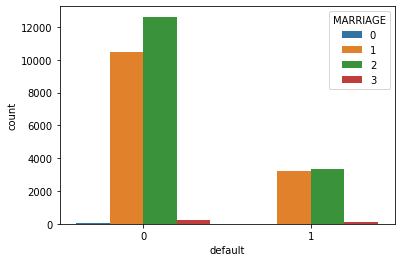

In [248]:
sns.countplot(df['default'], hue=df['MARRIAGE']);

Можно заметить, что доля холостых среди вернувших кредит больше отрывается от женатых, чем среди невернувших.

In [123]:
# посчитаем матрицу частот

confmat = pd.crosstab(df['default'], df['MARRIAGE'])
confmat

MARRIAGE,0,1,2,3
default,,,,
0,49,10453,12623,239
1,5,3206,3341,84


In [148]:
# вычислим коэффициент V Крамера
np.sqrt(scipy.stats.chi2_contingency(confmat)[0] / (df.shape[0] * (min(confmat.shape[0], confmat.shape[1]) - 1)))

0.034478203662766466

Коэффициент V Крамера близок к нулю, и потому мы можем сделать вывод об отсутствии взаимосвязи между переменными

### 5. Возраст

In [253]:
X_age0 = df[df['default'] == 0]['AGE'].values
X_age1 = df[df['default'] == 1]['AGE'].values

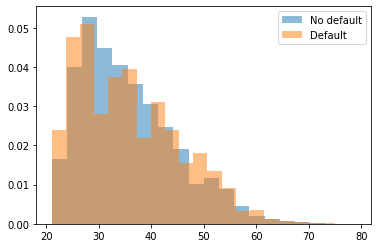

In [258]:
plt.hist(X_age0, bins=20, alpha=0.5, label='No default', density=True)
plt.hist(X_age1, bins=20, alpha=0.5, label='Default', density=True)
plt.legend(loc='upper right')
plt.show()

Распределения признаков похожи, судя по графику.

In [152]:

age0_median_scores = np.median(get_bootstrap_samples(X_age0, 1000), axis = 1)
age1_median_scores = np.median(get_bootstrap_samples(X_age1, 1000), axis = 1)

delta_median_scores = age0_median_scores - age1_median_scores
print("Доверительный интервал с на уровне доверия 95%",  stat_intervals(delta_median_scores, 0.05))

Доверительный интервал с на уровне доверия 95% [-1.  0.]


In [153]:
scipy.stats.mannwhitneyu(X_age0, X_age1)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

Доверительный интервал включает ноль и имеет длину 1, откуда следует, что различия в возрасте между группами несущественны. Достигаемый уровень значимости 0.18625 не даёт нам права отвергнуть гипотезу о равенстве распределений против альтернативы, что они различаются на сдвиг, на уровне значимости 0.05.
Мы можем принять гипотезу о равенстве медиан возрастов в группе.

Различие в один год между группами не является практически значимым.